# 1. Подготовка и предобработка данных

Импорт библиотек:

In [9]:
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, roc_curve, roc_auc_score, recall_score, precision_score  
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

Загрузим датасет и просмотрим первые 5 строк датасета, а также общую информацию о данных:

In [10]:
df = pd.read_csv('/datasets/Churn.csv')
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
RowNumber          10000 non-null int64
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             9091 non-null float64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


Целевой признак - `Exited` - категориальный признак, принимающий значение 0 или 1. Перед нами задача бинарной классификации.  
Признаки `RowNumber`, `CustomerId` ,  `Surname` нецелесообразно использовать в модели.  
Признаки `Geography`, `Gender` - категориальные, необходимо преобразовать их в численные для использования в модели.  
Остальные признаки - количественные (`CreditScore`, `Age`, `Tenure`, `Balance`, `NumOfProducts`, `EstimatedSalary`) или категориальные в бинарном формате (`HasCrCard`, `IsActiveMember`) - будем использовать в модели.

Приведем названия столбцов к нижнему регистру для удобства использования:

In [12]:
df.columns = df.columns.str.lower()
df.columns # проверка

Index(['rownumber', 'customerid', 'surname', 'creditscore', 'geography',
       'gender', 'age', 'tenure', 'balance', 'numofproducts', 'hascrcard',
       'isactivemember', 'estimatedsalary', 'exited'],
      dtype='object')

В столбце `tenure` есть пропуски. Предположим, что это те, у кого нет в собственности недвижимости - заполним пропуски нулями:

In [13]:
df.tenure = df.tenure.fillna(0)
df.tenure.isna().sum()

0

Проверим датасет на наличие дубликатов:

In [14]:
df.duplicated().sum() # дубликатов не обнаружено

0

Оценим распределения количественных переменных с помощью метода describe и графиков:

Распределение переменной creditscore
count    10000.000000
mean       650.528800
std         96.653299
min        350.000000
25%        584.000000
50%        652.000000
75%        718.000000
max        850.000000
Name: creditscore, dtype: float64


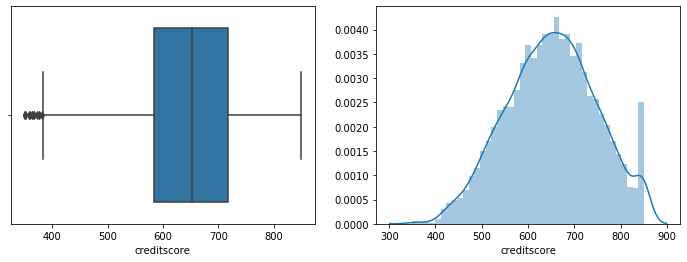


Распределение переменной age
count    10000.000000
mean        38.921800
std         10.487806
min         18.000000
25%         32.000000
50%         37.000000
75%         44.000000
max         92.000000
Name: age, dtype: float64


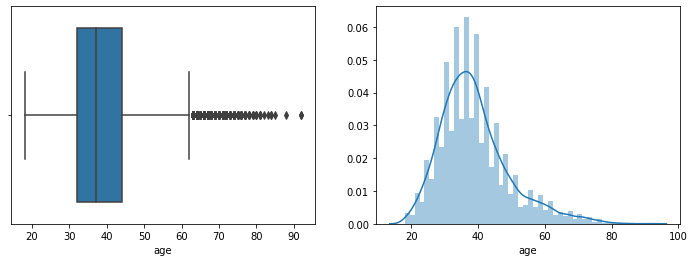


Распределение переменной tenure
count    10000.000000
mean         4.543400
std          3.111573
min          0.000000
25%          2.000000
50%          4.000000
75%          7.000000
max         10.000000
Name: tenure, dtype: float64


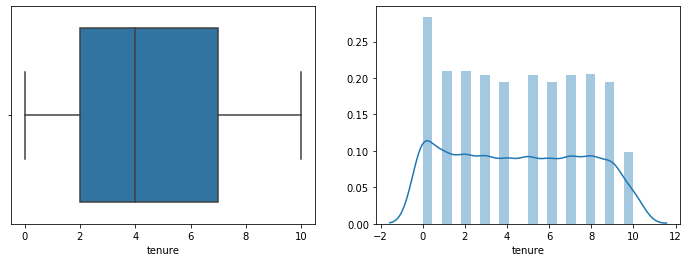


Распределение переменной balance
count     10000.000000
mean      76485.889288
std       62397.405202
min           0.000000
25%           0.000000
50%       97198.540000
75%      127644.240000
max      250898.090000
Name: balance, dtype: float64


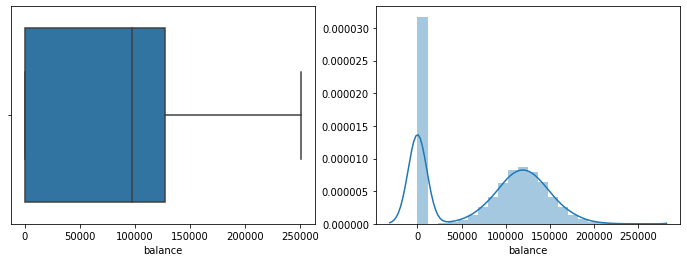


Распределение переменной numofproducts
count    10000.000000
mean         1.530200
std          0.581654
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max          4.000000
Name: numofproducts, dtype: float64


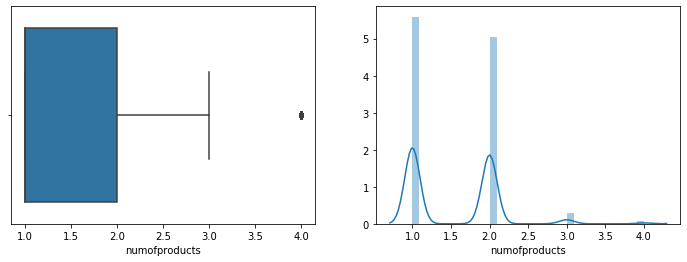


Распределение переменной estimatedsalary
count     10000.000000
mean     100090.239881
std       57510.492818
min          11.580000
25%       51002.110000
50%      100193.915000
75%      149388.247500
max      199992.480000
Name: estimatedsalary, dtype: float64


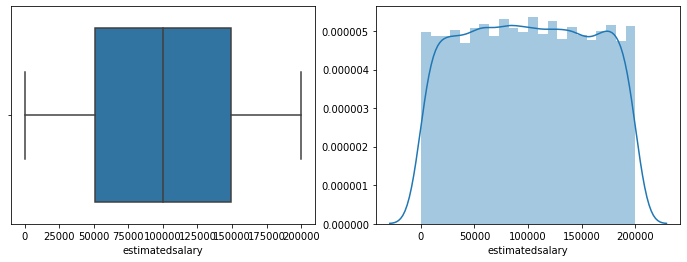

In [15]:
num_features = ['creditscore', 'age', 'tenure', 'balance', 'numofproducts', 'estimatedsalary']
for feature in num_features:
    print('Распределение переменной', feature)
    print(df[feature].describe())
    _, axes = plt.subplots(1, 2, figsize=(12, 4))
    sns.boxplot(x=feature, data=df, ax=axes[0])
    sns.distplot(df[feature], ax=axes[1])
    plt.show()
    print()

Первоначальные выводы по данным:

- Распределение кредитного рейтинга близко к нормальному, однако мы видим значительное число клиентов с максимальным кредитным рейтингом (850).  
- Распределение клиентов по возрасту скошено вправо, что логично - кредиты не выдаются до достижения совершеннолетия.  
- Количество недвижимости у клиента - целое число от 0 до 10, в среднем у клиента 4 объекта недвижимости.  
- Видим значительное число клиентов с нулевым балансом на счете, максимальный баланс - более 250 тыс.  
- В основном клиенты используют 1 или 2 банковских продукта, очень редко - 4 продукта.
- Среднее зарплата клиентов 100 тыс., максимальная - 200 тыс.

Признаки `geography`, `gender` преобразуем с помощью прямого кодирования, избегая дамми-ловушки:

In [16]:
df.geography.value_counts()

France     5014
Germany    2509
Spain      2477
Name: geography, dtype: int64

In [17]:
df.gender.value_counts()

Male      5457
Female    4543
Name: gender, dtype: int64

In [18]:
df_ohe = pd.get_dummies(df, columns=['geography', 'gender'], drop_first=True)
df_ohe.head() # новый датасет с дамми-признаками

,rownumber,customerid,surname,creditscore,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited,geography_Germany,geography_Spain,gender_Male
0,1,15634602,Hargrave,619,42,2.0,0.00,1,1,1,101348.88,1,0,0,0
1,2,15647311,Hill,608,41,1.0,83807.86,1,0,1,112542.58,0,0,1,0
2,3,15619304,Onio,502,42,8.0,159660.80,3,1,0,113931.57,1,0,0,0
3,4,15701354,Boni,699,39,1.0,0.00,2,0,0,93826.63,0,0,0,0
4,5,15737888,Mitchell,850,43,2.0,125510.82,1,1,1,79084.10,0,0,1,0


Разделим данные на обучающую, валидационную и тестовую выборки. Используем функцию train_test_split - сначала разделим данные на обучающую и валидационную выборки в соотношении 60:40, затем валидационную разобьем в соотношении 50:50, в итоге получим разбиение 60:20:20 обучающая-валидационная-тестовая выборки.

In [19]:
df_train, df_valid = train_test_split(df_ohe, test_size=0.4, random_state=12345) # разделим данные на обучающую и валидационную выборки
df_valid, df_test = train_test_split(df_valid, test_size=0.5, random_state=12345) # разделим валидационную выборку на тестовую и новую валидационную

features_train = df_train.drop(['exited', 'rownumber', 'customerid', 'surname'], axis=1) # признаки для обучения
target_train = df_train['exited'] # цель обучения

features_valid = df_valid.drop(['exited', 'rownumber', 'customerid', 'surname'], axis=1) # признаки для проверки
target_valid = df_valid['exited'] # цель проверки

features_test = df_test.drop(['exited', 'rownumber', 'customerid', 'surname'], axis=1) # тестовые признаки
target_test = df_test['exited'] # тестовая цель

Просмотрим размер получившихся выборок:

In [20]:
print(features_train.shape, target_train.shape)
print(features_valid.shape, target_valid.shape)
print(features_test.shape, target_test.shape)

(6000, 11) (6000,)
(2000, 11) (2000,)
(2000, 11) (2000,)


У численных признаков в датасете разный масштаб - необходимо привести их к одному масштабу. Стандартизируем численные признаки.

In [21]:
numeric = ['creditscore', 'age', 'tenure', 'balance', 'numofproducts', 'estimatedsalary']

scaler = StandardScaler() # cоздадим объект этой структуры
scaler.fit(features_train[numeric]) # настроим его на обучающих данных (вычисление среднего и дисперсии)

features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

features_train[numeric].head() # стандартизированные данные

,creditscore,age,tenure,balance,numofproducts,estimatedsalary
7479,-0.886751,-0.373192,1.104696,1.232271,-0.891560,-0.187705
3411,0.608663,-0.183385,1.104696,0.600563,-0.891560,-0.333945
6027,2.052152,0.480939,-0.503694,1.027098,0.830152,1.503095
1247,-1.457915,-1.417129,0.461340,-1.233163,0.830152,-1.071061
3716,0.130961,-1.132419,-0.825373,1.140475,-0.891560,1.524268


# 2. Обучение моделей без учёта дисбаланса классов

Посмотрим на баланс классов целевого признака:

In [22]:
target_train.value_counts()

0    4804
1    1196
Name: exited, dtype: int64

Объектов положительного класса в четыре раза меньше, чем отрицательного. Наблюдается дисбаланс классов. Для начала обучим модель без учёта дисбаланса.
Затем улучшим качество модели, учитывая дисбаланс классов.

Для решения задачи бинарной классификации построим следующие модели:  
- дерево решений;
- случайный лес;
- логистическую регрессию.  

Как метрику качества будем использовать *F1-меру* (подойдет в случае несбалансированных классов).  
Добавим также расчет метрик полноты и точности, понятных с точки зрения бизнеса. Полнота выявляет, какую долю положительных среди всех ответов выделила модель. Точность определяет, как много отрицательных ответов нашла модель, пока искала положительные.

### Подбор гиперпараметров вручную

Напишем функции для подбора гиперпараметров моделей путем перебора вручную.  

#### Дерево решений: подбор гиперпараметров вручную

In [23]:
def dtc(feat_train, targ_train):
        
    """ Функция для подбора гиперпараметров дерева решений.
    Принимает на вход обучающие признаки и целевой признак.
    Возвращает модель с наилучшими гиперпараметрами.
    
    """
    best_f1 = 0
    for l in ['entropy','gini']:
        for j in range(2,20,2):
            for k in range(2,15,2):
                model = DecisionTreeClassifier(max_depth=k, min_samples_split=j, criterion=l, random_state=12345)
                model.fit(feat_train, targ_train) # обучение модели
                f1_fit = f1_score(target_valid, model.predict(features_valid)) # проверка качества на валидационной выборке
                if f1_fit > best_f1:
                    best_f1 = f1_fit
                    best_j = j
                    best_k = k
                    best_l = l
                    model_dt = model
    print('Лучшие параметры дерева решений: max_depth =', best_k, 'min_samples_split =', best_j, 'criterion=', best_l)
    print('Лучшая F1-мера:', best_f1)
    print('Полнота:', recall_score(target_valid, model_dt.predict(features_valid))) 
    print('Точность:', precision_score(target_valid, model_dt.predict(features_valid)))
    print()
    return model_dt

model_dt = dtc(features_train, target_train)    

Лучшие параметры дерева решений: max_depth = 6 min_samples_split = 8 criterion= gini
Лучшая F1-мера: 0.5731523378582202
Полнота: 0.45454545454545453
Точность: 0.7755102040816326



#### Случайный лес: подбор гиперпараметров вручную

In [24]:
%%time

def rfc(feat_train, targ_train):
    """ Функция для подбора гиперпараметров случайного леса.
    Принимает на вход обучающие признаки и целевой признак.
    Возвращает модель с наилучшими гиперпараметрами.
    
    """
    best_f1 = 0
    for l in ['entropy','gini']:
        for i in range(3,15,2):
            for j in range(2,20,2):
                for k in range(2,15,2):
                    model = RandomForestClassifier(max_depth=k, n_estimators=i, min_samples_split=j, criterion=l, random_state=12345)
                    model.fit(feat_train, targ_train) # обучение модели
                    f1_fit = f1_score(target_valid, model.predict(features_valid)) # проверка качества на валидационной выборке
                    if f1_fit > best_f1:
                        best_f1 = f1_fit
                        best_j = j
                        best_i = i
                        best_k = k
                        best_l = l
                        model_rf = model
    print('Лучшие параметры случайного леса: max_depth =', best_k, 'estim =', best_i, 'min_samples_split =', best_j, 'criterion =', best_l)
    print('Лучшая F1-мера:', best_f1)
    print('Полнота:', recall_score(target_valid, model_rf.predict(features_valid))) 
    print('Точность:', precision_score(target_valid, model_rf.predict(features_valid)))
    print()
    return model_rf

model_rf = rfc(features_train, target_train)  

Лучшие параметры случайного леса: max_depth = 12 estim = 11 min_samples_split = 16 criterion = gini
Лучшая F1-мера: 0.6158357771260996
Полнота: 0.5023923444976076
Точность: 0.7954545454545454

CPU times: user 51.3 s, sys: 158 ms, total: 51.4 s
Wall time: 51.6 s


#### Логистическая регрессия: подбор гиперпараметров вручную

In [25]:
def lr(feat_train, targ_train):
    """ Функция для подбора гиперпараметров логистической регрессии.
    Принимает на вход обучающие признаки и целевой признак.
    Возвращает модель с наилучшими гиперпараметрами.
    
    """
    best_f1 = 0
    for l in ['balanced', None]:
        for i in ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']:
            model = LogisticRegression(class_weight=l, solver=i, random_state=12345)
            model.fit(feat_train, targ_train) # обучение модели
            f1_fit = f1_score(target_valid, model.predict(features_valid)) # проверка качества на валидационной выборке
            if f1_fit > best_f1:
                best_f1 = f1_fit
                best_i = i
                best_l = l
                model_lr = model
    print('Лучшие параметры логистической регрессии: solver =', best_i, 'class_weight =', best_l)
    print('Лучшая F1-мера:', best_f1)
    print('Полнота:', recall_score(target_valid, model_lr.predict(features_valid))) 
    print('Точность:', precision_score(target_valid, model_lr.predict(features_valid)))
    print()
    return model_lr

model_lr = lr(features_train, target_train)   

Лучшие параметры логистической регрессии: solver = newton-cg class_weight = balanced
Лучшая F1-мера: 0.4888888888888888
Полнота: 0.6842105263157895
Точность: 0.3803191489361702



Дополнительно измерим AUC-ROC, сравним её значение с F1-мерой. Построим графики ROC-кривых.  
Напишем функцию для расчета AUC-ROC и построения графиков:

DecisionTreeClassifier без учёта дисбаланса AUC-ROC= 0.8205371130964983


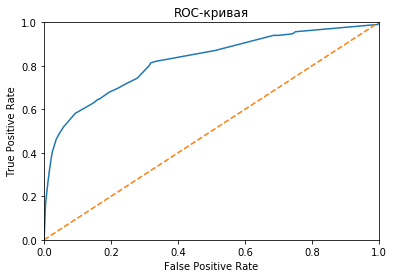

RandomForestClassifier без учёта дисбаланса AUC-ROC= 0.8340118195730678


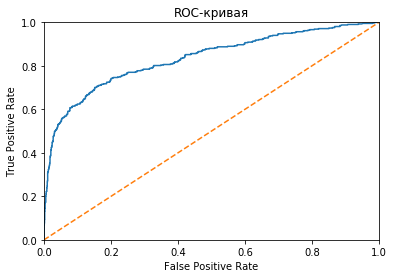

LogisticRegression без учёта дисбаланса AUC-ROC= 0.7634905848692528


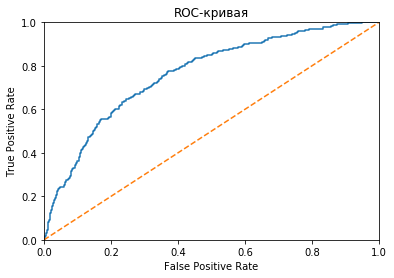

In [26]:
def aucroc(model, model_name):
    """ Функция для расчета AUC-ROC и построения графиков.
    Принимает на вход модель и название модели.
    Возвращает значение AUC-ROC и строит график ROC-кривой.
    
    """
    probabilities_valid = model.predict_proba(features_valid)
    probabilities_one_valid = probabilities_valid[:, 1]
    auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
    print(model_name, 'AUC-ROC=', auc_roc)
    
    fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
    plt.figure()
    plt.plot(fpr, tpr)
    # ROC-кривая случайной модели (выглядит как прямая)
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlim([0, 1])  # установим границы осей от 0 до 1
    plt.ylim([0, 1])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC-кривая") 
    plt.show()
    return auc_roc

models = [model_dt, model_rf, model_lr]
models_names = ['DecisionTreeClassifier без учёта дисбаланса', 'RandomForestClassifier без учёта дисбаланса', 'LogisticRegression без учёта дисбаланса']
for i in range(len(models)):
    aucroc(models[i], models_names[i])

### Вывод

Лучших результатов при переборе параметов удалось добиться на модели случайного леса: F1-мера на валидационной выборке равна 0.616.  
Логистическая регрессия на несбалансированных классах дает совсем низкое качество, при взвешивании классов (агрумент class_weight='balanced') F1-мера повышается, но все равно остается ниже, чем у других моделей.

Площадь под ROC-кривой — AUC-ROC у построенных нами моделей больше, чем у случайной модели (AUC-ROC случайной модели равна 0.5). Из графиков также видно, что модели лучше случайной. Самое высокое значение auc_roc = 0.834 у модели случайного леса.

### Подбор гиперпараметров с помощью GridSearchCV

Также проведем поиск гиперпараметров с помощью GridSearchCV.  
При реализации GridSearchCV используем метрику F1(scoring='f1'), однако полученные значения будут отличаться от метрик качества, получаемых на валидационной выборке. GridSearchCV делает внутри себя кросс-валидацию, и выдает усредненное качество на тестовой части обучающей выборки. Поэтому для корректного сравнения моделей посчитаем f1_score на валидационной выборке по моделям с гиперпараметрами, рассчитанными с помощью GridSearchCV.

#### Дерево решений: подбор гиперпараметров с помощью GridSearchCV

In [27]:
%%time

grid_search = GridSearchCV(estimator=DecisionTreeClassifier(),
                           param_grid={'criterion':['entropy','gini'],
                                       'max_depth': range(2,11),
                                       'min_samples_split':range(2,11,2),
                                       'random_state':[12345],
                                       'min_samples_leaf': range(2,11)},
                           scoring='f1', cv=3, n_jobs=-1
                           )

grid_search.fit(features_train, target_train)

model_dt_grid_search = grid_search.best_estimator_
best_param = grid_search.best_params_
best_score = grid_search.best_score_

print('Лучшие параметры дерева решений:', best_param)
print('Лучшая f1-мера, рассчитанная GridSearchCV:', best_score)
print()

Лучшие параметры дерева решений: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 9, 'min_samples_split': 2, 'random_state': 12345}
Лучшая f1-мера, рассчитанная GridSearchCV: 0.5677720119205945

CPU times: user 49.3 s, sys: 53.2 ms, total: 49.4 s
Wall time: 50.1 s


#### Случайный лес: подбор гиперпараметров с помощью GridSearchCV 

In [28]:
%%time 

grid_search = GridSearchCV(estimator=RandomForestClassifier(),
                           param_grid={'criterion':['entropy','gini'],
                                       'max_depth': range(2,11),
                                       'n_estimators': range(3,11,2),
                                       'min_samples_split':range(2,11,2),
                                       'random_state':[12345],
                                       'min_samples_leaf': range(2,4)},
                           scoring='f1', cv=3, n_jobs=-1
                           )

grid_search.fit(features_train, target_train)

model_rf_grid_search = grid_search.best_estimator_
best_param = grid_search.best_params_
best_score = grid_search.best_score_

print('Лучшие параметры случайного леса:', best_param)
print('Лучшая f1-мера, рассчитанная GridSearchCV:', best_score)
print()

Лучшие параметры случайного леса: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 9, 'random_state': 12345}
Лучшая f1-мера, рассчитанная GridSearchCV: 0.5631835637907311

CPU times: user 1min 24s, sys: 311 ms, total: 1min 24s
Wall time: 1min 25s


#### Логистическая регрессия: подбор гиперпараметров с помощью GridSearchCV

In [29]:
%%time

grid_search = GridSearchCV(estimator=LogisticRegression(),
             param_grid={'class_weight': (None, 'balanced'), 
                         'solver': ('newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'),
                         'random_state': [12345]},
             scoring='f1', cv=3
                          )

grid_search.fit(features_train, target_train)

model_lr_grid_search = grid_search.best_estimator_
best_param = grid_search.best_params_
best_score = grid_search.best_score_

print('Лучшие параметры логистической регрессии:', best_param)
print('Лучшая f1-мера, рассчитанная GridSearchCV:', best_score)
print()

Лучшие параметры логистической регрессии: {'class_weight': 'balanced', 'random_state': 12345, 'solver': 'newton-cg'}
Лучшая f1-мера, рассчитанная GridSearchCV: 0.49553288972024406

CPU times: user 5.29 s, sys: 4.09 s, total: 9.38 s
Wall time: 9.33 s


Посчитаем f1_score на валидационной выборке по моделям с гиперпараметрами, рассчитанными с помощью GridSearchCV.

In [30]:
model_dt_grid_search.fit(features_train, target_train) # обучение моделей
model_rf_grid_search.fit(features_train, target_train)
model_lr_grid_search.fit(features_train, target_train)

f1_dt_grid_search = f1_score(target_valid, model_dt_grid_search.predict(features_valid)) # проверка качества на валидационной выборке
f1_rf_grid_search = f1_score(target_valid, model_rf_grid_search.predict(features_valid))
f1_lr_grid_search = f1_score(target_valid, model_lr_grid_search.predict(features_valid))

print('F1-мера дерева решений', f1_dt_grid_search)
print('F1-мера случайного леса', f1_rf_grid_search)
print('F1-мера логистической регрессии', f1_lr_grid_search)

F1-мера дерева решений 0.5612104539202202
F1-мера случайного леса 0.5723172628304821
F1-мера логистической регрессии 0.4888888888888888


### Вывод

После подбора гиперпараметров с помощью GridSearchCV и расчета F1-метрики на валидационной выборке мы получили качество модели несколько хуже, чем при ручном поиске (лучший результат получили у случайного леса: F1-мера = 0.572). Чтобы снизить время вычислений, при GridSearchCV задан несколько более узкий диапазон параметров, что и дало меньшее значение F1 меры.

# 3. Устранение дисбаланса классов

Для устранения дисбаланса классов используем техники upsampling (скопировать несколько раз положительные объекты) и  downsampling (случайным образом отбросить часть отрицательных объектов).

### Увеличение выборки - техника upsampling 

In [31]:
def upsample(features, target, repeat):
    
    """ Функция для устранения дисбаланса классов техникой upsampling.
    Принимает на вход обучающую выборку, целевой признак и параметр repeat.
    Возвращает новую обучающую выборку и целевой признак.
    
    """
    # разделим обучающую выборку на отрицательные и положительные объекты
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

features_upsampled, target_upsampled = upsample(features_train, target_train, 3)

print(features_upsampled.shape)

(8392, 11)


### Уменьшение выборки - техника downsampling  

In [32]:
def downsample(features, target, fraction):
    
    """ Функция для устранения дисбаланса классов техникой downsampling.
    Принимает на вход обучающую выборку, целевой признак и параметр fraction.
    Возвращает новую обучающую выборку и целевой признак.
    
    """
    # разделим обучающую выборку на отрицательные и положительные объекты
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

features_downsampled, target_downsampled = downsample(features_train, target_train, 0.25)

print(features_downsampled.shape)

(2397, 11)


## Подбор гиперпараметров моделей после устранения дисбаланса классов

Если считать метрику качества на выборке, которую предварительно изменили с помощью апсемплинга/даунсемплинга, то значение посчитанной метрики будет смещено от истинного значения. Соответственно использовать GridSearchCV на выборке после апсемплинга/даунсемплинга неправильно. Посчитаем метрику F1 с помощью написанных нами функций.

### Дерево решений

Дерево решений после апсемплинга:

In [33]:
model_destr_best = dtc(features_upsampled, target_upsampled)

Лучшие параметры дерева решений: max_depth = 6 min_samples_split = 2 criterion= entropy
Лучшая F1-мера: 0.5956566701137539
Полнота: 0.6889952153110048
Точность: 0.5245901639344263



Дерево решений после даунсемплинга:

In [34]:
dtc(features_downsampled, target_downsampled)

Лучшие параметры дерева решений: max_depth = 4 min_samples_split = 2 criterion= entropy
Лучшая F1-мера: 0.5936842105263158
Полнота: 0.6746411483253588
Точность: 0.5300751879699248



DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=4,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=12345, splitter='best')

Лучший результат у модели дерева решений после апсемплинга - F1-мера 0.596

### Случайный лес

Случайный лес после апсемплинга:

In [35]:
model_ranfor_best = rfc(features_upsampled, target_upsampled)

Лучшие параметры случайного леса: max_depth = 6 estim = 13 min_samples_split = 14 criterion = gini
Лучшая F1-мера: 0.639080459770115
Полнота: 0.6650717703349283
Точность: 0.6150442477876106



Случайный лес после даунсемплинга:

In [36]:
rfc(features_downsampled, target_downsampled)

Лучшие параметры случайного леса: max_depth = 4 estim = 9 min_samples_split = 6 criterion = gini
Лучшая F1-мера: 0.6097318768619662
Полнота: 0.7344497607655502
Точность: 0.5212224108658744



RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=4, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=6,
                       min_weight_fraction_leaf=0.0, n_estimators=9,
                       n_jobs=None, oob_score=False, random_state=12345,
                       verbose=0, warm_start=False)

Лучший результат у модели случайного леса после апсемплинга: F1-мера 0.639, Полнота: 0.665, Точность: 0.615

### Логистическая регрессия

Логистическая регрессия после апсемплинга:

In [37]:
model_logreg_best = lr(features_upsampled, target_upsampled)

Лучшие параметры логистической регрессии: solver = newton-cg class_weight = None
Лучшая F1-мера: 0.5014985014985014
Полнота: 0.6004784688995215
Точность: 0.4305317324185249



Логистическая регрессия после даунсемплинга:

In [38]:
lr(features_downsampled, target_downsampled)

Лучшие параметры логистической регрессии: solver = newton-cg class_weight = balanced
Лучшая F1-мера: 0.4892703862660944
Полнота: 0.6818181818181818
Точность: 0.3815261044176707



LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=12345, solver='newton-cg', tol=0.0001,
                   verbose=0, warm_start=False)

Лучший результат у модели логистической регресии после апсемплинга: F1-мера 0.501

Дополнительно измерим AUC-ROC моделей после устранения дисбаланса классов, сравним их значение с F1-мерой. Построим графики

DecisionTreeClassifier после апсемплинга AUC-ROC= 0.8171368687204738


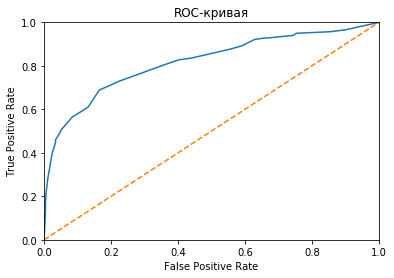

RandomForestClassifier после апсемплинга AUC-ROC= 0.8483341297733472


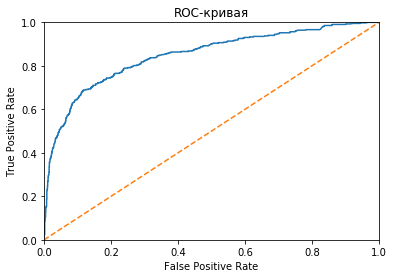

LogisticRegression после апсемплинга AUC-ROC= 0.7624940266998954


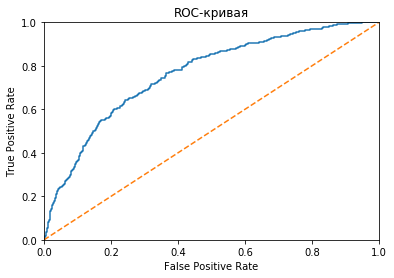

In [40]:
models = [model_destr_best, model_ranfor_best, model_logreg_best]
models_names = ['DecisionTreeClassifier после апсемплинга', 'RandomForestClassifier после апсемплинга', 'LogisticRegression после апсемплинга']
for i in range(len(models)):
    aucroc(models[i], models_names[i])

### Вывод 

После апсемплинга качество моделей выросло значительнее, чем после даунсемплинга. После устранения дисбаланса классов самое высокое качество мы получили у модели случайного леса после апсемплинга: F1-мера 0.639, Полнота: 0.665, Точность: 0.615. Значение auc_roc у модели случайного леса 0.848. Из графика ROC-кривой также видно, что модель значительно лучше случайной. 

# 4. Тестирование модели

Проведем финальное тестирование наилучшей модели (случайный лес после апсемплинга) на тестовой выборке.

In [41]:
print("F1-score модели RandomForestClassifier на тестовой выборке:", f1_score(target_test, model_ranfor_best.predict(features_test)))
print('Полнота:', recall_score(target_test, model_ranfor_best.predict(features_test))) 
print('Точность:', precision_score(target_test, model_ranfor_best.predict(features_test)))

F1-score модели RandomForestClassifier на тестовой выборке: 0.6137931034482759
Полнота: 0.6312056737588653
Точность: 0.5973154362416108


Полученное значение F1-score модели RandomForestClassifier на тестовой выборке: 0.614 удовлетворяет нашему условию (получить метрику не меньше 0.59). 

# 5. Общий вывод

Для прогнозирования ухода клиента из банка был устранен дисбаланс классов, наилучший результат показала модель случайного леса со значением F1-меры на тестовой выборке 0.614 (Полнота: 0.631, Точность: 0.597). 